# Part 2: Feature Engineering

## Imports and settings

In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed
import re
import sys
import unicodedata
import json
from bertopic import BERTopic
from sklearn.decomposition import PCA


/opt/anaconda3/envs/telegram_chat_clustering_2/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Get the parent directory of the current notebook directory and add it to the python path to import custom modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

First, we'll import the cleaned dataset and check, if we retained the datatypes.

In [3]:
path = os.path.join(os.getcwd(), "../data/csv/cleaned_data.csv")
dtypes_path = os.path.join(os.getcwd(), '../data/auxiliary/cleaned_data_dtypes.json')

# load datatypes
with open(dtypes_path, 'r') as f:
    dtypes_dict = json.load(f)
    
# isolate datetime and non-datetime columns
datetime_cols = [col for col, dtype in dtypes_dict.items() if dtype == 'datetime64[ns]']
dtype_dict_nodate = {col: dtype for col, dtype in dtypes_dict.items() if dtype != 'datetime64[ns]'}

# load cleaned dataset using the types defined above
df = pd.read_csv(path, low_memory=False, parse_dates=datetime_cols, dtype=dtype_dict_nodate)
df.shape

(1581498, 39)

In [4]:
#create a dataframe to compare the original datatypes and the datatypes of the imported dataframe
dtypes_df = pd.DataFrame({
    'Saved Data Types': dtypes_dict,
    'Current Data Types': df.dtypes
})
display(dtypes_df)
differences_df = dtypes_df[dtypes_df['Saved Data Types'] != dtypes_df['Current Data Types']]
print(f"Number of mismatched data-types: {differences_df.shape[0]}")

,Saved Data Types,Current Data Types
chat_handle,object,object
chat_name,object,object
chat_type,object,object
collection_time,datetime64[ns],datetime64[ns]
fwd_from_chat_handle,object,object
fwd_from_chat_id,Int64,Int64
fwd_from_user_name,object,object
is_fwd,bool,bool
is_group_elem,bool,bool
is_reply,bool,bool


Number of mismatched data-types: 0


## Preprocessing


Before we create the features, we preproess the columns that contain text we want to embed using SBERT. 

SBERT is a bidirectional encoder, meaning it considers both preceding and following words, thereby accounting for a sentence's structure and context. To preserve as much of this structure and context as possible, we will retain stopwords and regular punctuation. The preprocessing steps will include:

1. **Combining Text Fields**: We will concatenate the webpage title and description into a single text field for embedding later on.

2. **Isolating References:** We isolate telegram chat handles referenced in links and mentions

3. **Handling Missing Values**: Any NaN values in the text columns will be replaced with empty strings to ensure seamless processing later on.

4. **Removing Markdown Artifacts**: Since Telegram supports markdown, we will clean the text by removing any artifacts related to Telegram's markdown formatting.

5. **Removing URLs**: We will remove any URLs present in the text.

6. **Removing Emojis**: We remove the emojis, but retain a version of the text including them, as they might be usefull later on.

7. **Normalize styled text**: Some Telegram Users use styled text (for example: 𝒾𝒹𝑜𝓇𝓊). We normalize them to include them in the embedding. 

8. **Removing multiple whitespaces**


If we have already performed the preprocessing in earlier runs of the notebook, we'll re-load the preprocessed dataframe. 


In [5]:
# check if we already preprocessed the data in earlier runs. If so, load the preprocessed data.
preprocessed_path = os.path.join(os.getcwd(), "../data/preprocessed/df_preprocessed.pkl")
preprocessed = os.path.isfile(preprocessed_path)
if preprocessed:
    print(f"Already preprocessed: {preprocessed}")
    df = pd.read_pickle(preprocessed_path)

Already preprocessed: True


#### Combine Text Fields:

In [6]:
# add webpage titles to their description
if not preprocessed:
    df["webpage_texts"] = df["webpage_title"] + df["webpage_description"]

#### Isolate Chat Handles referenced by Links:

In [7]:
# isolate telegram links
if not preprocessed:
    
    url_extraction_pattern = r"(https?:\/\/[^\s/$.?#].[^\s]*[^\s.,?!)](?![\])]))|(www\.[^\s/$.?#].[^\s]*[^\s.,?!)](?![\])]))"
    link_brackets_pattern = r"[()\[\]]"

    extracted_links = (df["message_text"]
                    .str.replace(link_brackets_pattern, " ", regex=True) # remove brackets, as they might interfere with the regex
                    .str.strip("_") # remove trailing whitespaces, as they are most likely markdown artifacts
                    .str.strip("*") # remove trailing asterisks, as they are most likely markdown artifacts
                    .str.strip("~") # remove trailing tildes, as they are most likely markdown artifacts
                    .str.extractall(url_extraction_pattern)) 

    # reset index to convert the multiindex to columns we can work with
    extracted_links = extracted_links.reset_index()
    
    # only keep telegram urls
    extracted_links = extracted_links[(extracted_links[0].str.contains(r"https?:\/\/t\.me", na=False)) | (extracted_links[1].str.contains(r"www\.t\.me", na=False))]
    
    # remove message identifiers that might be appended to the end of telegram urls
    message_id_pattern = r"/\d+$"
    extracted_links[0] = extracted_links[0].str.replace(message_id_pattern, '', regex=True)
    extracted_links[1] = extracted_links[1].str.replace(message_id_pattern, '', regex=True)
    
    # get the telegram chat handle, that should now be at the end of the url
    chat_handle_pattern = r"/(\w+$)"
    extracted_links[0] = extracted_links[0].str.extract(chat_handle_pattern)
    extracted_links[1] = extracted_links[1].str.extract(chat_handle_pattern)

    # group extracted links by the message they were extracted from
    grouped = extracted_links.groupby("level_0")

    # aggregate the links of each message
    aggregated_links = grouped.agg(lambda x: list(x.dropna())).reset_index()
    aggregated_links["combined"] = aggregated_links.apply(lambda row: row.iloc[2] + row.iloc[3], axis=1)

    # Prepare for merging
    aggregated_links = aggregated_links[["level_0", "combined"]]
    aggregated_links.columns = ['original_index', 'telegram_links']
    aggregated_links.set_index('original_index', inplace=True)

    # add mentioned chat handles to the original df
    df = df.join(aggregated_links, how='left')

#### Fill NaN Values:

In [8]:
# Fill nan values with empty strings
if not preprocessed:
    df["message_text"] = df["message_text"].fillna('')
    df["webpage_texts"] = df["webpage_texts"].fillna('')

#### Remove URLs:

In [9]:
# remove urls
if not preprocessed:
    url_pattern = r"\(?\bhttps?:\/\/[^\s/$.?#].[^\s]*[^\s.,?!)]\)?|\(?\bwww\.[^\s/$.?#].[^\s]*[^\s.,?!)]\)?"
    df["message_text"] = df["message_text"].str.replace(url_pattern, '', regex=True)
    df["webpage_texts"] = df["webpage_texts"].str.replace(url_pattern, '', regex=True)

#### Isolate mentioned Chat Handles:

In [10]:
# isolate mentioned chats
if not preprocessed:
    mentions_pattern =  r"@(\w+)" 
    extracted_mentions = df["message_text"].str.extractall(mentions_pattern)
    
    # reset index to convert the multiindex to columns we can work with
    extracted_mentions = extracted_mentions.reset_index()
    
    # we dont include trailing whitespaces, as they are most likely markdown artifacts.    
    extracted_mentions[0] = extracted_mentions[0].str.strip("_") 
    
    # group extracted mentions by the message they were extracted from
    grouped = extracted_mentions.groupby("level_0")
    
    # aggregate the mentions of each message
    aggregated_mentions = grouped.agg(lambda x: list(x.dropna())).reset_index()

    # Prepare aggregated_mentions for merging
    aggregated_mentions = aggregated_mentions[["level_0", 0]]
    aggregated_mentions.columns = ['original_index', 'mentions']
    aggregated_mentions.set_index('original_index', inplace=True)

    # add aggreagted links to the original df
    df = df.join(aggregated_mentions, how='left')

#### Combine References:

In [11]:
if not preprocessed:

    # combine chat handles referenced in links and mentions into a single list. Remove handles referenced more than once per message.
    df['referenced_chat_handles'] = df.apply(
        lambda row: list(set((row['mentions'] if isinstance(row['mentions'], list) else []) +
                    (row['telegram_links'] if isinstance(row['telegram_links'], list) else []))),
        axis=1
    )

    # convert empty lists to NaN
    df['referenced_chat_handles'] = df['referenced_chat_handles'].apply(lambda x: x if x else np.nan)

    with pd.option_context('display.max_colwidth', None):
        display(df[["mentions", "telegram_links",  "referenced_chat_handles"]].head())

#### Remove Markdown Artifacts:

In [12]:
# remove markdown-artifacts
if not preprocessed:
    bold_pattern = r"\*\*|__"
    italic_pattern = r"\*|_"
    strikethrough_pattern = r"~~"
    link_brackets_pattern = r"[()\[\]]"

    df["message_text"] = (
        df["message_text"]
        .str.replace(bold_pattern, '', regex=True)
        .str.replace(italic_pattern, '', regex=True)
        .str.replace(strikethrough_pattern, '', regex=True)
        .str.replace(link_brackets_pattern, '', regex=True)
    )

    df["webpage_texts"] = (
        df["webpage_texts"]
        .str.replace(bold_pattern, '', regex=True)
        .str.replace(italic_pattern, '', regex=True)
        .str.replace(strikethrough_pattern, '', regex=True)
        .str.replace(link_brackets_pattern, '', regex=True)
    )

#### Remove URLs:

In [13]:
# remove urls again, as some were surrounded by brackets before
if not preprocessed:
    url_pattern = r"\(?\bhttps?:\/\/[^\s/$.?#].[^\s]*[^\s.,?!)]\)?|\(?\bwww\.[^\s/$.?#].[^\s]*[^\s.,?!)]\)?"
    df["message_text"] = df["message_text"].str.replace(url_pattern, '', regex=True)
    df["webpage_texts"] = df["webpage_texts"].str.replace(url_pattern, '', regex=True)

#### Remove Emojis:

In [14]:
# create a list of emoji-unicodes using data from "https://unicode.org/Public/emoji/15.1/"
if not preprocessed:
    
    def load_emoji_list(file_paths: list[str]) -> list[str]:
        """
        Load a list of all emoji from the given file paths.
        Args:
            file_paths (list): A list of file paths to load emoji sequences from.
        Returns:
            list: A list of unicode sequences representing the loaded emoji sequences.
        """
        
        unicode_list = []

        # match lines with unicode, including ranges like 231A..231B 
        range_pattern = re.compile(r"([0-9A-Fa-f]{4,6})\.\.([0-9A-Fa-f]{4,6})\s*;\s*")
        code_point_pattern = re.compile(r"([0-9A-Fa-f]{4,6}(?:\s[0-9A-Fa-f]{4,6})*)\s*;\s*")

        for file_path in file_paths:
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()

            for line in lines:
                range_match = range_pattern.match(line)
                
                # add elements of ranges as individual codes to list
                if range_match:
                    start_code, end_code = range_match.groups()
                    start_int = int(start_code, 16)
                    end_int = int(end_code, 16)
                    unicode_list.extend([chr(code) for code in range(start_int, end_int + 1)])
                else:
                    code_match = code_point_pattern.match(line)
                    if code_match:
                        code_points = code_match.group(1)       
                        code_point_list = code_points.split()
                        # create zwj sequences by combining all code points
                        unicode_list.append(''.join([chr(int(code, 16)) for code in code_point_list]))

        return unicode_list

    # list the paths to the unicode-files
    path_1 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-sequences.txt")
    path_2 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-test.txt")
    path_3 = os.path.join(os.getcwd(), "../data/auxiliary/emoji_unicode/emoji-zwj-sequences.txt")
    file_paths = [path_1, path_2, path_3]

    # load all emojis from the unicode-files
    emoji_sequences = load_emoji_list(file_paths)

    # create a regex pattern from the emoji sequence
    emoji_pattern = '|'.join(re.escape(emoji) for emoji in emoji_sequences)

In [15]:
# remove emojis (this will take a while, so we parallelize the process)

def demojize_chunk(chunk, emoji_pattern):
    # keep text including emojis in a seperate column
    chunk["message_text_emoji"] = chunk["message_text"]
    # remove emojis
    chunk["message_text"] = chunk["message_text"].str.replace(emoji_pattern, " ", regex=True)
    return chunk

n_jobs = 3  # Use three cores (seems to be fastest?)

# apply the preprocessing in parallel to each chunk
if not preprocessed:
    chunks = np.array_split(df, n_jobs)
    df_chunks = Parallel(n_jobs=n_jobs)(delayed(demojize_chunk)(chunk, emoji_pattern) for chunk in chunks)
    df = pd.concat(df_chunks, ignore_index=True)

In [16]:
df.shape

(1581498, 43)

#### Normalize Styled Scripts

In [17]:
# normalize styled scripts

def normalize_style(text):
    # remove characters that dont normalize
    text = re.sub(r'[𝔄-𝔷𝒜-𝓏𝗔-𝗭𝗮-𝗯]', '', text)
    # normalize Unicode
    text = unicodedata.normalize('NFKC', text)
    return text

if not preprocessed:
    df["message_text"] = df["message_text"].apply(lambda x: normalize_style(x))


#### Remove multiple Whitespaces

In [18]:
# remove duplicated whitespaces
if not preprocessed:
    df['message_text'] = df['message_text'].str.replace(r'\s+', ' ', regex=True)

#### Save preprocessed Data for future runs:

In [19]:
# save preprocessed dataframe
if not preprocessed:
    path = os.path.join(os.getcwd(), "../data/preprocessed/df_preprocessed.pkl")
    df.to_pickle(path)

## Feature 0: Baseline Embeddings

First, we will create document embeddings based on a chats message text. 

This is the most frequently used approach to vectorizing Telegram-Chats and will serve as a baseline for comparison in this experiment.

### 1. Load model

In [20]:
current_path = os.getcwd()
model_dir = os.path.join(current_path, "../data/models/")
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
model_path = os.path.join(model_dir, model_name)

# Load or download the model
if not os.path.isdir(model_path):
    print("Model not found. Downloading...")
    model = SentenceTransformer(model_name)
    model.save(model_path)
    print(f"Model saved to {model_path}")
else:
    print(f"Model already downloaded. Loading...")
    model = SentenceTransformer(model_path)

Model already downloaded. Loading...


### 2. Create Message-Embeddings

To create the baseline chat-embeddings, we first define the functions we'll use to create the embeddings for each message. To speed the process up, we'll also provide a function to do so in parallel. 


-> REALLY???
Afterwards, we'll take the mean of the message-embeddings of each chat to create document embeddings.

In [21]:
def get_embeddings(text, default_embedding, model):
    """
    Get embeddings for the given text using a specified model.
    Parameters:
    text (str): The input text to encode.
    default_embedding: The default embedding to return if the input text is empty or NaN.
    model: The model used for encoding the text.
    Returns:
    numpy.ndarray: The embeddings of the input text.
    """
    
    if pd.isna(text) or text.strip() == '':
        return default_embedding
    
    return model.encode(text, convert_to_tensor=False)


def process_chunk_with_saving(chunk, chunk_index, default_embedding, model, tmp_dir):
    """
    Process a chunk of text data by computing embeddings for each text and saving the embeddings for future use.
    Args:
        chunk (list): A list of text data.
        chunk_index (int): The index of the chunk.
        default_embedding: The default embedding to use if a text is empty or NaN.
        model: The embedding model to use for computing embeddings.
        tmp_dir (str): The directory to temporarily store the embeddings of the chunk.
    Returns:
        numpy.ndarray: The computed embeddings for the chunk.
    """
    

    # create path to temporarily store this chunk
    chunk_path = os.path.join(tmp_dir, f"chunk_{chunk_index}.npy")
    
    if os.path.isfile(chunk_path):
        # load the precomputed embeddings if they were already created
        print(f"Chunk #{chunk_index} already embedded. Loading...")
        return np.load(chunk_path)
    
    print(f"Processing chunk #{chunk_index}...")
    embeddings = []

    for text in chunk:
        embedding = get_embeddings(text, default_embedding, model)
        embeddings.append(embedding)

    # Save the embeddings for this chunk
    embeddings = np.array(embeddings)
    np.save(chunk_path, embeddings)
    
    return embeddings


Now we create the embeddings. 
To avoid redundant calculations, we'll only calculate the embeddings if we have not saved them yet. If they are already in our project, we'll simply load them.

In [22]:
# check if the embeddings were already saved.
message_embeddings_path = os.path.join(os.getcwd(), '../features/0_message_embeddings.npy')
message_embeddings_df_path = os.path.join(os.getcwd(), '../features/0_message_embeddings.csv')
already_vectorized = (os.path.isfile(message_embeddings_path) and os.path.isfile(message_embeddings_df_path))
print(f"Already created: {already_vectorized}")

Already created: True


In [23]:
# calculate embeddings if they have not already been created

if not already_vectorized:
    
    print("Embeddings not yet created. Vectorizing...")

    df_embeddings = df.copy()

    # set environment variable to control tokenizers parallelism
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

    # define default embedding
    default_embedding = np.zeros((model.get_sentence_embedding_dimension(),))

    # split DataFrame into chunks for parallel processing
    num_chunks = 3  # three seems to work fastest
    df_chunks = np.array_split(df_embeddings["message_text"], num_chunks)
    
    # set up the directory to save intermediate results
    output_dir = os.path.join(os.getcwd(), "../tmp")
    os.makedirs(output_dir, exist_ok=True)

    # process each chunk in parallel and save intermediate results to limit the impact of crashes
    results = Parallel(n_jobs=num_chunks)(
        delayed(process_chunk_with_saving)(chunk, chunk_index, default_embedding, model, output_dir) 
        for chunk_index, chunk in enumerate(df_chunks)
    )

    # combine results into a single df
    df_embeddings["message_text_embeddings"] = np.concatenate(results).tolist()
    
    # save the final df with embeddings as a csv
    df_embeddings.to_csv(message_embeddings_df_path)
    print(df_embeddings.shape)
    
    # save the embeddings separately as a np array
    embeddings_array = np.array(df_embeddings["message_text_embeddings"].tolist())
    np.save(message_embeddings_path, embeddings_array)

else:
    # loading the whole dataframe takes about 45min. Instead we'll load only the embeddings and add them to the dataframe we loaded earlier (this takes ca. 2min)
    print("Embeddings already created. Loading Embeddings...")
    #feature = ['message_text_embeddings']
    #embeddings = pd.read_csv(message_embeddings_df_path, skipinitialspace=True, usecols=feature)
    embeddings = np.load(message_embeddings_path)
    df_embeddings = df.copy()
    df_embeddings["message_text_embeddings"] = embeddings.tolist() # converting to list to save one array per row

Embeddings already created. Loading Embeddings...


### 3. Create Chat Representations

Now we can create chat representations by averaging the embeddings of each message in a chat. 

To do so, we will take the mean of all messages belonging to a chat while ignoring the zero-vectors created for empty messages, as they could drag the average down.

In [24]:
base_path = os.path.join(os.getcwd(), "../features/0_base_chat_vectors.npy")
already_created =  os.path.exists(base_path)
print(f"Already created: {already_created}")

Already created: True


In [25]:
def aggregate_embeddings(embeddings: pd.Series) -> np.ndarray:
    """
    Aggregate embeddings by taking their mean and ignoring zero-embeddings.
    Args:
        embedding (pd.Series(np.array)): Embeddings to aggregate
    Returns:
        np.array: The aggregated embedding
    """
    
    non_zero_embeddings = [emb for emb in embeddings if not np.all(emb == 0)]
    # vertically stack the non zero message embeddings into a matrix and take the mean for each column to aggregate embeddings
    if non_zero_embeddings:
        aggregation = np.mean(np.vstack(non_zero_embeddings), axis=0)
        return aggregation
    # return a zero vector if all embeddings are zero
    else:
        return np.zeros_like(embeddings.iloc[0])  
    

if not already_created:
    print("No vectors found. Creating chat representations.")
    base_chat_representations = df_embeddings.groupby('telegram_chat_id')['message_text_embeddings'].apply(aggregate_embeddings)

    # save the representations
    base_chat_representations.to_pickle(base_path)
    
else:
    print("Vectors found. Loading chat representations.")
    base_chat_representations = pd.read_pickle(base_path)

Vectors found. Loading chat representations.


## Feature 1: Filtered Chat Representations

**The Problem:**

Datasets sourced from Telegram are often created by tracking forwarded messages across chats to identify new sources for data collection. Consequently, forwarded messages frequently appear in multiple chats, including both their original source and the chats where they were forwarded.

Chat representations that include all messages from a chat often contain implicit connections between chats. This is because duplicated message text can make chats appear more similar than if they were merely discussing the same topics.

**The Feature:**

To address this, our first feature will be chat representations that exclude messages forwarded from or to other chats within the dataset. This way, we will be able to evaluate the impact of the forward-driven data collection process has on clustering and the similarity of chat representations.

To create them, we'll:

1. Filter the dataset to omitt any forwarded messages between chats in the dataset.

2. Create aggregated embeddings and topic distributions based on the filtered messages to represent our chats.

#### 1: Filter the Dataset

To filter out implicit connections between chats containing forwarded messages and chats that contain their original versions, we simply remove all instances where both a forwarded message and its source are present in our dataset.

To avoid repeating the operation each time we run the notebook, we'll save the indices of the remaining messages. These indices will be used in subsequent runs to filter the data.

In [26]:
# check if we already filtered the dataset
feature_1_path = os.path.join(os.getcwd(), "../features/1_implicit_ref_filtered.csv")
indices_path = os.path.join(os.getcwd(), "../features/1_implicit_ref_filtered_indices.npy")

filtered = os.path.isfile(indices_path) and os.path.isfile(feature_1_path)
print(f"Data already filtered: {filtered}")

Data already filtered: True


In [27]:
if not filtered: 
    
    print("Data not yet filtered. Filtering...")
    
    df_references_filtered = df_embeddings.copy()

    # group messages according to their message text
    grouped = df_references_filtered.groupby("message_text")

    # Filter the dataset. True indicates that either the source chat and original message of a duplicates are in our dataset, 
    # or that one of the duplicates chat id is the source chat of one of the duplicates.
    fwds_with_source = grouped.apply(
        lambda group: group['fwd_from_chat_id'].isin(group['telegram_chat_id']) | group['telegram_chat_id'].isin(group['fwd_from_chat_id']),
        include_groups=False
    )

    # filter the dataframe to remove messages of which we have either the original or a forwarded instance of in the dataset 
    msg_to_keep = fwds_with_source[fwds_with_source == False]
    msg_to_keep = msg_to_keep.reset_index()
    msg_to_keep_indices = msg_to_keep["level_1"].to_list() #level 1 contains the original row indices 
    df_references_filtered = df_references_filtered.loc[msg_to_keep_indices]

    print(f"Removed {abs(df.shape[0] - df_references_filtered.shape[0])} messages.")

    print("Saving filtered data...")
    df_references_filtered.to_csv(feature_1_path)    

    print("Saving indices...")
    indices_array = np.array(df_references_filtered.index)
    np.save(indices_path, indices_array)
    
else:
    print("Data already filtered. Using saved indices to (re)filter the data...")
    filtered_rows_indices = np.load(indices_path)
    df_references_filtered = df_embeddings.loc[filtered_rows_indices]

Data already filtered. Using saved indices to (re)filter the data...


#### 2: Create Chat Representations

Next, we create chat representations by aggregating the embeddings of the message left in the filtered dataset.

In [28]:
filtered_chat_path = os.path.join(os.getcwd(), "../features/1_filtered_chat_vectors.npy")
already_created =  os.path.exists(filtered_chat_path)
print(f"Already created: {already_created}")

Already created: True


In [29]:
if not already_created:
    print("No vectors found. Creating chat representations.")
    # for each chat: vertically stack the message embeddings into a matrix and take the mean for each column to create chat embeddings
    filtered_chat_representations = df_references_filtered.groupby('telegram_chat_id')['message_text_embeddings'].apply(aggregate_embeddings) 

    # save the representations
    filtered_chat_representations.to_pickle(filtered_chat_path)
    
else:
    print("Vectors found. Loading chat representations.")
    filtered_chat_representations = pd.read_pickle(filtered_chat_path)

Vectors found. Loading chat representations.


## Feature 2: Structural Attributes

Next, we create a representation of our chats structural attributes. Structural attributes describe a chats connections to other telegram entities. 

For our purposes, we will consider two kinds of connections:

1. Forwarded messages between chats.

2. Mentions of chats or other telegram-entities.

To vectorise these connection, we will perform the following steps:

1. We construct an adjacency matrix representing the frequency of forwarded messages from one chat to another in our dataset.

2. We construct an adjacency matrix based on the chats referenced in links and mentions sent in each chat.

#### 1. Create the Forward Matrix

An adjacency matrix is a standard representation of a graph where each cell indicates the number of connections between nodes. In our case, the columns represent the source chats of messages, and the row indices represent the chats in our dataset.

Due to limitations in the data collection process, the current adjacency matrix does not capture all forward-based relationships between chats. Instead, it only reflects the incoming connections observed within the data collection timeframe.

To create a comprehensive adjacency matrix, we will:

1. Isolate Rows with forwarded messages


2. Construct the Adjacency Matrix


3. Add Chats with no forwarded messages

We'll start with isolating rows with forwarded messages and create the initial adjacency matrix.

In [30]:
# isolate rows that contain messages forwarded from another chat
fwd_messages = df[~(pd.isna(df["fwd_from_chat_id"]))]

# create the adjacency matrix 
adj_matrix_fwd = fwd_messages.pivot_table(
                            index='telegram_chat_id', 
                            columns='fwd_from_chat_id', 
                            aggfunc='size', # count the number of occurrences of each combination of telegram_chat_id and fwd_from_chat_id
                            fill_value=0) # fills all cells with no co-occurances of chat and source-chat with 0
adj_matrix_fwd.head()

fwd_from_chat_id,1000249388,1002276352,1002362600,1002489027,1003201003,1006487902,1006499585,1006503122,1008810857,1009650918,...,2239286766,2239304560,2240498869,2242503750,2242527103,2243517654,2244138096,2244914709,2247229261,2248949529
telegram_chat_id,,,,,,,,,,,,,,,,,,,,,
1100528049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106758760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1127888562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129215099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129446959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we check, if we have chats without any forwarded messages in our dataset and if they are already in the matrix.

In [31]:
# group messages by chat they were sent in
grouped = df.groupby("telegram_chat_id")

# get the chat ids of all chats, that have zero messages forwarded from public chats
def all_nans(series):
    return series.isna().all()
no_fwd_chats = grouped["fwd_from_chat_id"].apply(all_nans)
no_fwd_chats = no_fwd_chats[no_fwd_chats==True].index

# check if the Adjacency Matrix already contains the chats we identified
index_adj_matrix = adj_matrix_fwd.index
in_matrix = []
not_in_matrix = []

for index in no_fwd_chats:
    if index in (index_adj_matrix):
        in_matrix.append(index)
    else:
        not_in_matrix.append(index)
        
print(f"{len(in_matrix)}/{len(no_fwd_chats)} chats without forwarded messages are already in the matrix.")

0/13 chats without forwarded messages are already in the matrix.


As we found some chats containting no forwards, we'll add them to the matrix manually.

In [32]:
# create the adjacency matrix for non-forward chats
non_fwd_adj_matrix = pd.DataFrame(index=not_in_matrix, columns=adj_matrix_fwd.columns)
non_fwd_adj_matrix.fillna(0,inplace=True) # set all values to 0, as these chats have no connections.

# add them to the initial matrix
adj_matrix_fwd = pd.concat([adj_matrix_fwd, non_fwd_adj_matrix], axis=0)
adj_matrix_fwd

fwd_from_chat_id,1000249388,1002276352,1002362600,1002489027,1003201003,1006487902,1006499585,1006503122,1008810857,1009650918,...,2239286766,2239304560,2240498869,2242503750,2242527103,2243517654,2244138096,2244914709,2247229261,2248949529
1100528049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1106758760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1127888562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129215099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129446959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419385125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1527918321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1624340376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1695508103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before moving on to creating the correlation matrix, we need to check if each chat is represented in our adjacency matrix.

In [33]:
initial_chat_count = df["telegram_chat_id"].nunique()
adj_matrix_chat_count = adj_matrix_fwd.shape[0]
print(f"Number of chats in dataset: {initial_chat_count}")
print(f"Number of chats in Adjacency Matrix: {adj_matrix_chat_count}")

Number of chats in dataset: 351
Number of chats in Adjacency Matrix: 351


Finally, we can apply some regularisation to the matrix. 

We'll create two versions:

- **Log-Normalized Matrix**: Using logarithmic scaling to balance extreme values.

- **One-Hot Encoded Matrix**: Converting categorical features into a binary format.

We'll also visualize them.

**1: Log-Normalized Matrix**

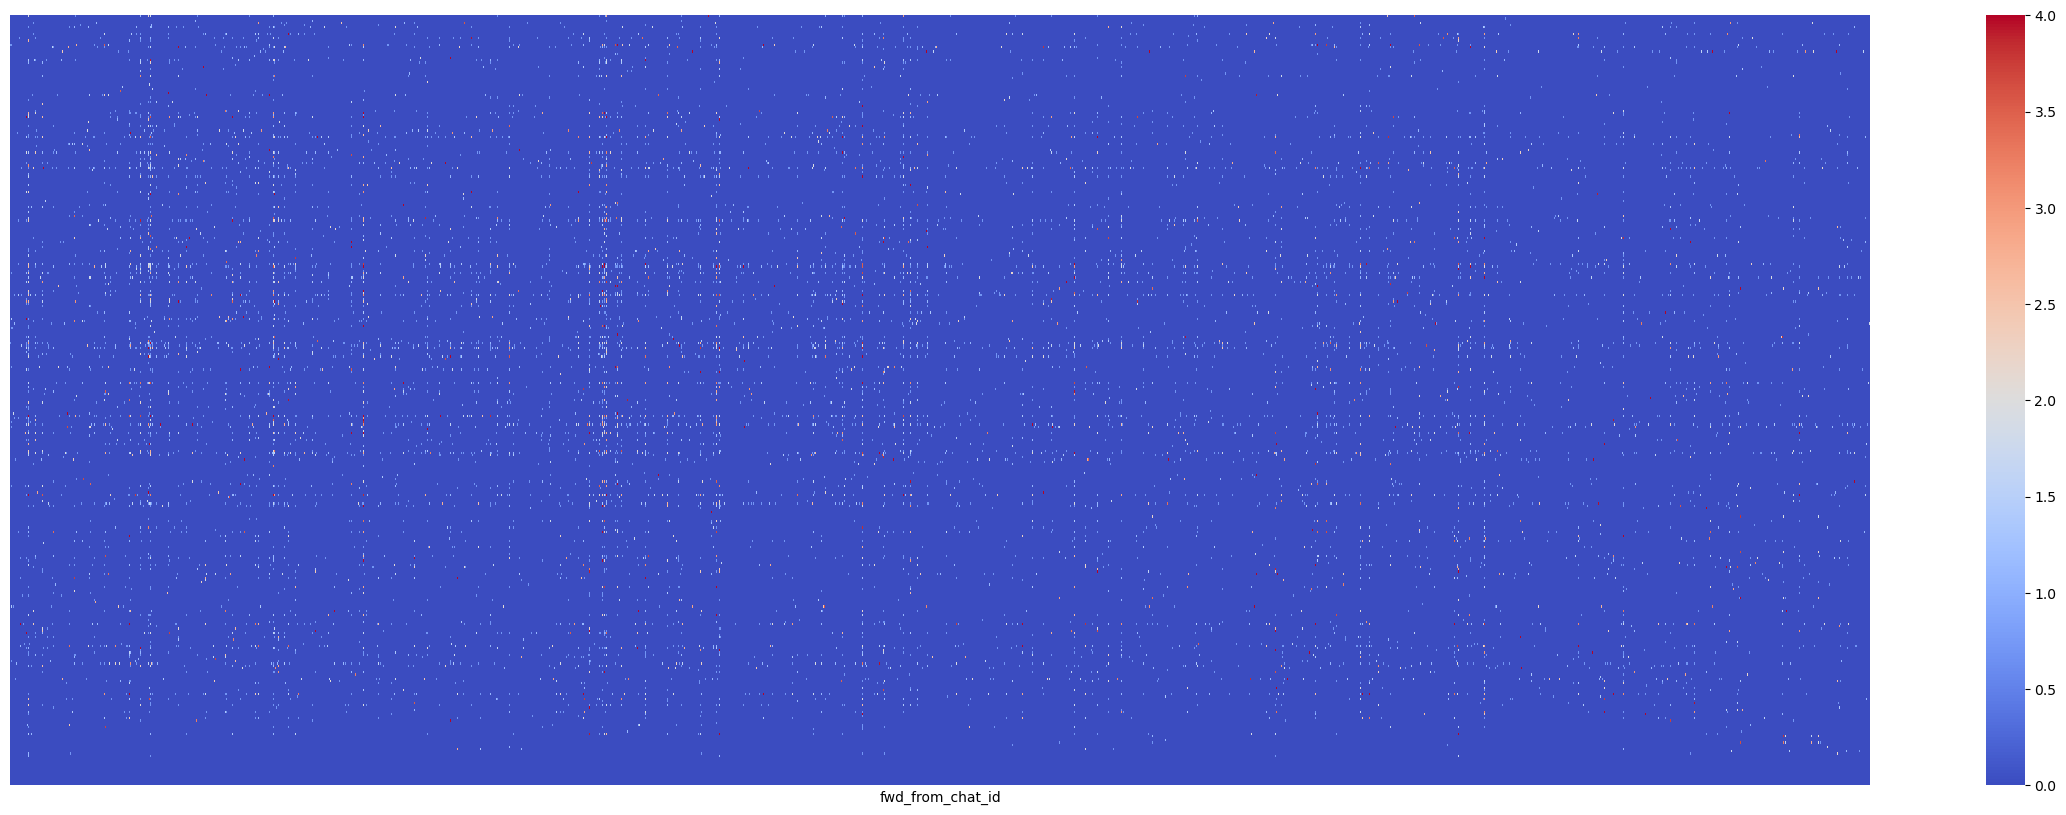

In [34]:
# apply logarithmic scaling to the matrix
adj_matrix_fwd_log_scaled = np.log1p(adj_matrix_fwd)  # np.log1p is log(x + 1) to handle zeros

adj_matrix_fwd_log_scaled = pd.DataFrame(adj_matrix_fwd_log_scaled, 
                                     index=adj_matrix_fwd.index, 
                                     columns=adj_matrix_fwd.columns)


# display the normalized adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_fwd_log_scaled, annot=False, cmap='coolwarm', vmax=4)
plt.xticks([])
plt.yticks([])
plt.show()

# save the adjacency matrix
adj_matrix_fwd_log_scaled_path = os.path.join(os.getcwd(), "../features/2_log_fwd_matrix.npy")
np.save(adj_matrix_fwd_log_scaled_path, adj_matrix_fwd_log_scaled)

**2: One-Hot Encoded Matrix**

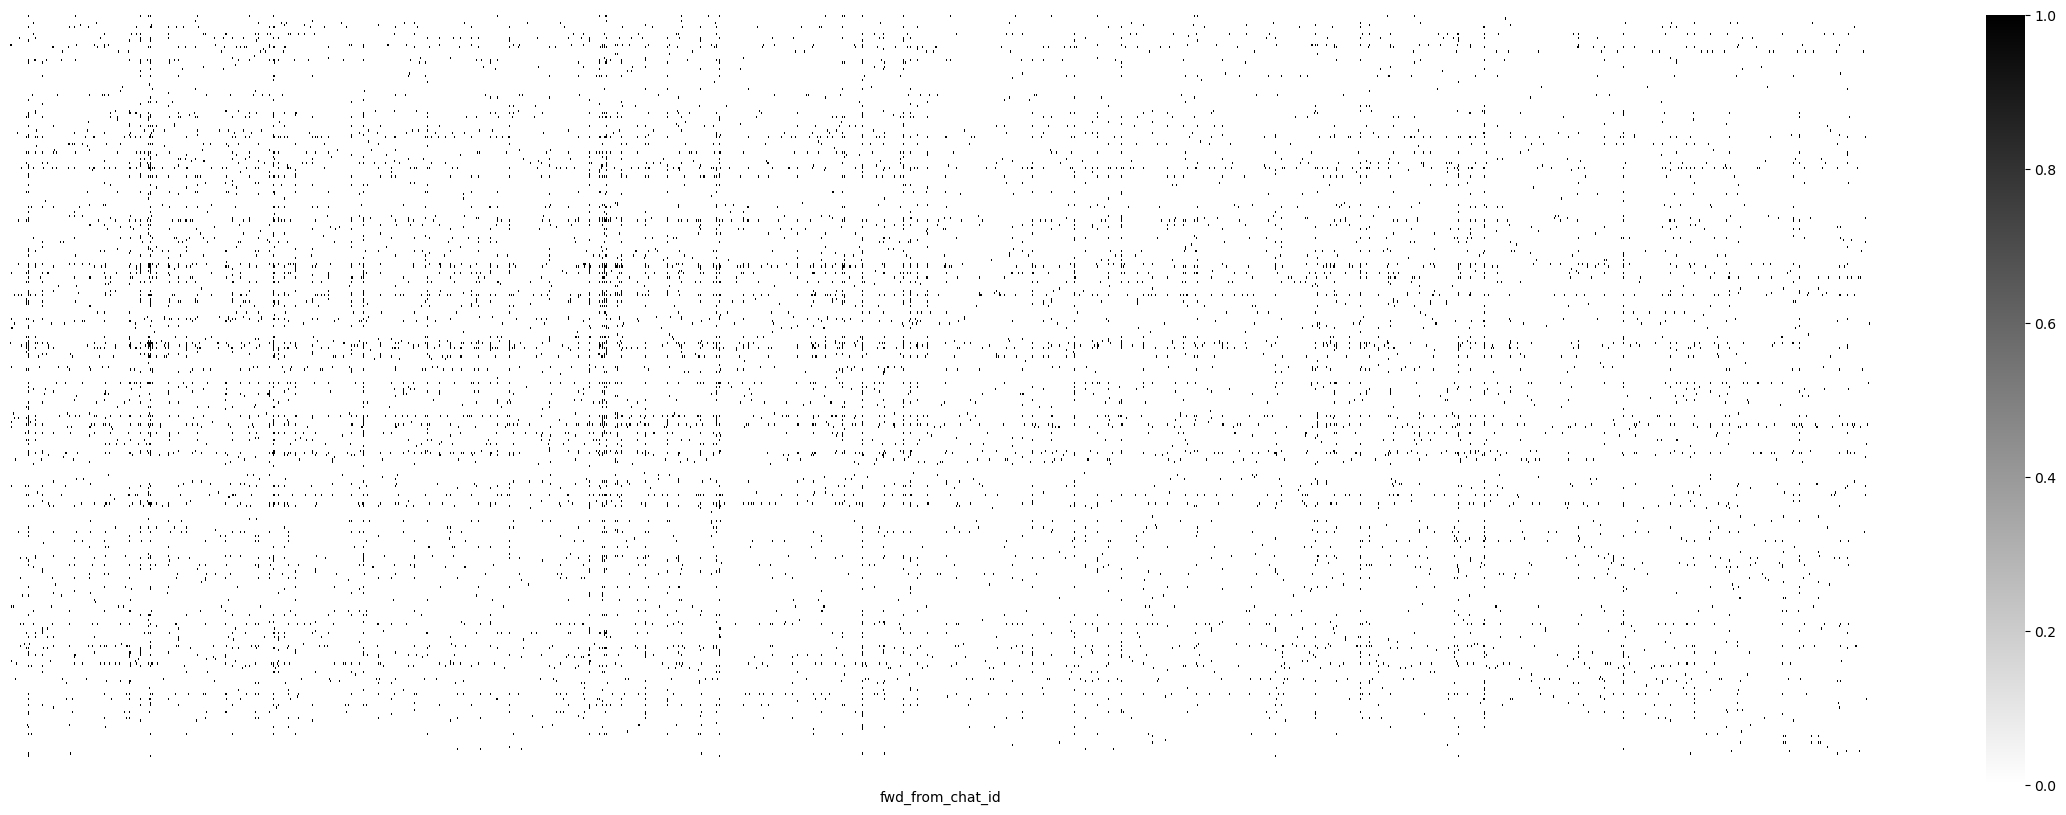

In [35]:
adj_matrix_fwd_one_hot = adj_matrix_fwd.map(lambda x: 0 if x==0 else 1)

# display the one hot encoded adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_fwd_one_hot, annot=False, cmap='gist_yarg')
plt.xticks([])
plt.yticks([])
plt.show()

# save the adjacency matrix
adj_matrix_fwd_one_hot_path = os.path.join(os.getcwd(), "../features/2_onehot_fwd_matrix.npy")
np.save(adj_matrix_fwd_one_hot_path, adj_matrix_fwd_one_hot)

#### 2. Create the Reference Matrix

Next, we isolate all messages that contain a reference to another telegram entity based on links and mentions. 

To do so, we'll isolate the chat handles mentioned in each message and the message's origin-chat's ID. 
We'll also want to remove self-references, as we're only interesed in conncetions between chats. 

In [41]:
# isolate references
references = df[["telegram_chat_id", "chat_handle", "referenced_chat_handles"]]

# explode the "mentions" column to get a individual row for each reference in a message
references_exploded = references.explode('referenced_chat_handles')

# remove self-references
references_exploded = references_exploded[~(references_exploded["chat_handle"].str.lower() == references_exploded["referenced_chat_handles"].str.lower())]
references_exploded

,telegram_chat_id,chat_handle,referenced_chat_handles
0,1368846992,BeforeOurTime,NaN
2,1417164314,AzazelNews,NaN
3,1417164314,AzazelNews,NaN
4,1284455740,Xavier_Naidoo,mediathek_neues_unter_der_sonne
4,1284455740,Xavier_Naidoo,Lebensmuthotline
...,...,...,...
1581495,1436459644,NaN,DieWahrheitssuchende
1581496,1436459644,NaN,DieWahrheitssuchende
1581496,1436459644,NaN,derwegdeswissens____
1581496,1436459644,NaN,bilderfreude____


As we can see, there are some chat handles missing. 

As attempts to add the missing chat handles using the Telegram API were severely impacted by rate-limits, we will remove chats with missing handles.

In [42]:
references_exploded = references_exploded[~pd.isna(references_exploded["chat_handle"])]
print(f" Number of rows with missing chat_handle: {pd.isna(references_exploded["chat_handle"]).sum()}")

 Number of rows with missing chat_handle: 0


Now we can create the adjacency matrix based on references to other telegram entities in messages.

In [43]:
adj_matrix_ref = references_exploded.pivot_table(
    index='chat_handle', 
    columns='referenced_chat_handles', 
    aggfunc='size', # count the number of occurrences of each combination of telegram_chat_id and fwd_from_chat_id
    fill_value=0) # fills all cells with no co-occurances of chat and source-chat with 0

adj_matrix_ref

referenced_chat_handles,,0STUNDE,1,100rabhsingh781,10103__,10106__,10121__,10132__,10169__,10192__,...,т,ть,тьхохлов,шим,юны,я,ᵃˡˡ,𝐂ơơƙıŋɠῳıɬɧᏝσʋ,𝔭𝔦𝔵𝔞𝔟𝔞𝔶,𝗞𝗹𝗮𝗴𝗲𝗺𝗮𝘂𝗲𝗿𝗧𝗩
chat_handle,,,,,,,,,,,,,,,,,,,,,
AGENTM2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANewDay144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AUFSTIEG5DOFFIZIELL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AllesAusserMainstream,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AnettGatzka,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whl_kanal_tierseelenhilfe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
widerstandFBade,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wissenistmacht1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Afterwards, we check if there are any chats in our dataset that contain no links or mentions to any other telegram entity or reference only themself. 

If so, we manually add them to our matrix and set all values to zero.

In [44]:
grouped = df.groupby("telegram_chat_id")

# get all chats that have zero references to other chats in form of links and mentions
references_per_group = grouped["referenced_chat_handles"].sum()
no_ref = references_per_group[references_per_group==0]

# create a dictionary of available Chat-Handle/ID-pairings to get the handles corresponding to the IDs of the chats without references
available_chats = df[["telegram_chat_id","chat_handle"]].value_counts()
available_chats = available_chats.reset_index().drop(columns=["count"], axis=1)
available_chats = available_chats.set_index("telegram_chat_id")
available_chats = available_chats["chat_handle"].to_dict()

# get the chat handles of the chats containing no references.
no_ref = no_ref.index.map(available_chats).tolist()

# get the chat handles of chats that reference only themselves
# aggregate all references of a chat into a single list per chat
grouped_references = grouped["referenced_chat_handles"].agg(lambda x: list(set([item for sublist in x if isinstance(sublist, list) for item in sublist])))
# keep only chats that have references to exactly one other chat
only_one_ref = grouped_references[grouped_references.apply(lambda x: len(x)) == 1]
# map the 'telegram_chat_id' index to its corresponding chat handle
only_one_ref.index = only_one_ref.index.map(available_chats)
# reset index to make 'telegram_chat_id' a column again
only_one_ref = only_one_ref.reset_index()
# explode the 'referenced_chat_handles' column to separate list elements into individual rows
only_one_ref = only_one_ref.explode("referenced_chat_handles")
# filter the rows where 'telegram_chat_id' is the same as 'referenced_chat_handles'
only_self_ref = only_one_ref[only_one_ref["telegram_chat_id"] == only_one_ref["referenced_chat_handles"]]
# extract the 'telegram_chat_id' column values where the chat references itself
only_self_ref = only_self_ref["telegram_chat_id"]
only_self_ref = only_self_ref.tolist()

# combine the list of chats containing no references or only references to themselves
zero_ref = no_ref + only_self_ref

# check if the Adjacency Matrix already contains the chats we identified
index_adj_matrix = adj_matrix_ref.index
in_matrix = []
not_in_matrix = []

for index in zero_ref:
    if index in (index_adj_matrix):
        in_matrix.append(index)
    else:
        not_in_matrix.append(index)
        
print(f"{len(in_matrix)}/{len(zero_ref)} chats without forwarded messages are already in the matrix.")

0/9 chats without forwarded messages are already in the matrix.


In [40]:
# create the adjacency matrix for chats containing no references
non_ref_adj_matrix = pd.DataFrame(index=not_in_matrix, columns=adj_matrix_ref.columns)
non_ref_adj_matrix.fillna(0,inplace=True) # set all values to 0, as these chats have no references.

# add them to the initial matrix
adj_matrix_ref = pd.concat([adj_matrix_ref, non_ref_adj_matrix], axis=0)
adj_matrix_ref

referenced_chat_handles,,0STUNDE,1,100rabhsingh781,10103__,10106__,10121__,10132__,10169__,10192__,...,т,ть,тьхохлов,шим,юны,я,ᵃˡˡ,𝐂ơơƙıŋɠῳıɬɧᏝσʋ,𝔭𝔦𝔵𝔞𝔟𝔞𝔶,𝗞𝗹𝗮𝗴𝗲𝗺𝗮𝘂𝗲𝗿𝗧𝗩
AGENTM2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANewDay144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AUFSTIEG5DOFFIZIELL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AllesAusserMainstream,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AnettGatzka,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BlackoutNewsDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
disclosurenews,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dimis_dimi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KunstDerFotografie,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, we can apply some regularisation to the matrix and display it. We'll again create a log-scaled matrix and a one-hot-encoded matrix.

**1: Log-Normalized Matrix:**

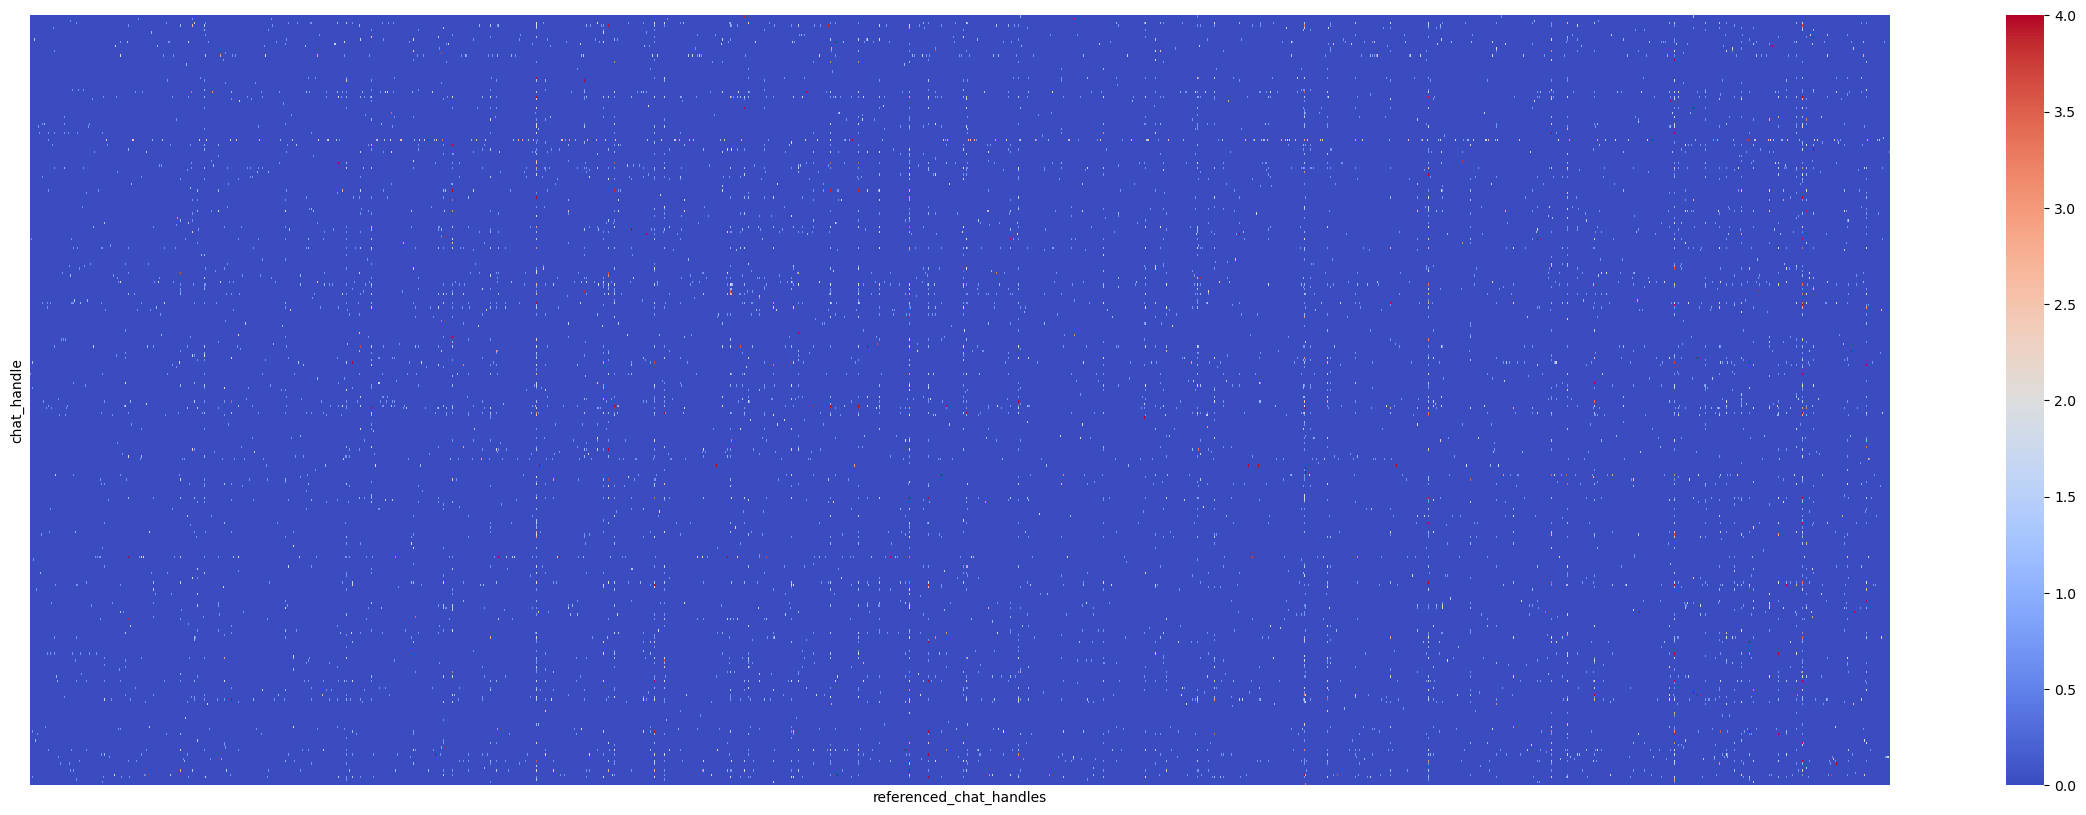

In [45]:
# Apply logarithmic scaling to the matrix
adj_matrix_ref_log_scaled = np.log1p(adj_matrix_ref)  # np.log1p is log(x + 1) to handle zeros


adj_matrix_ref_log_scaled = pd.DataFrame(adj_matrix_ref_log_scaled, 
                                     index=adj_matrix_ref.index, 
                                     columns=adj_matrix_ref.columns)


# Display the normalized adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_ref_log_scaled, annot=False, cmap='coolwarm', vmax=4) #vmax is set to 4 to make the colors more distinguishable
plt.xticks([])
plt.yticks([])
plt.show()

# save the adjacency matrix
adj_matrix_ref_log_path = os.path.join(os.getcwd(), "../features/2_log_ref_matrix.npy")
np.save(adj_matrix_ref_log_path, adj_matrix_ref_log_scaled)

**2: One-Hot-Encoded Matrix:**

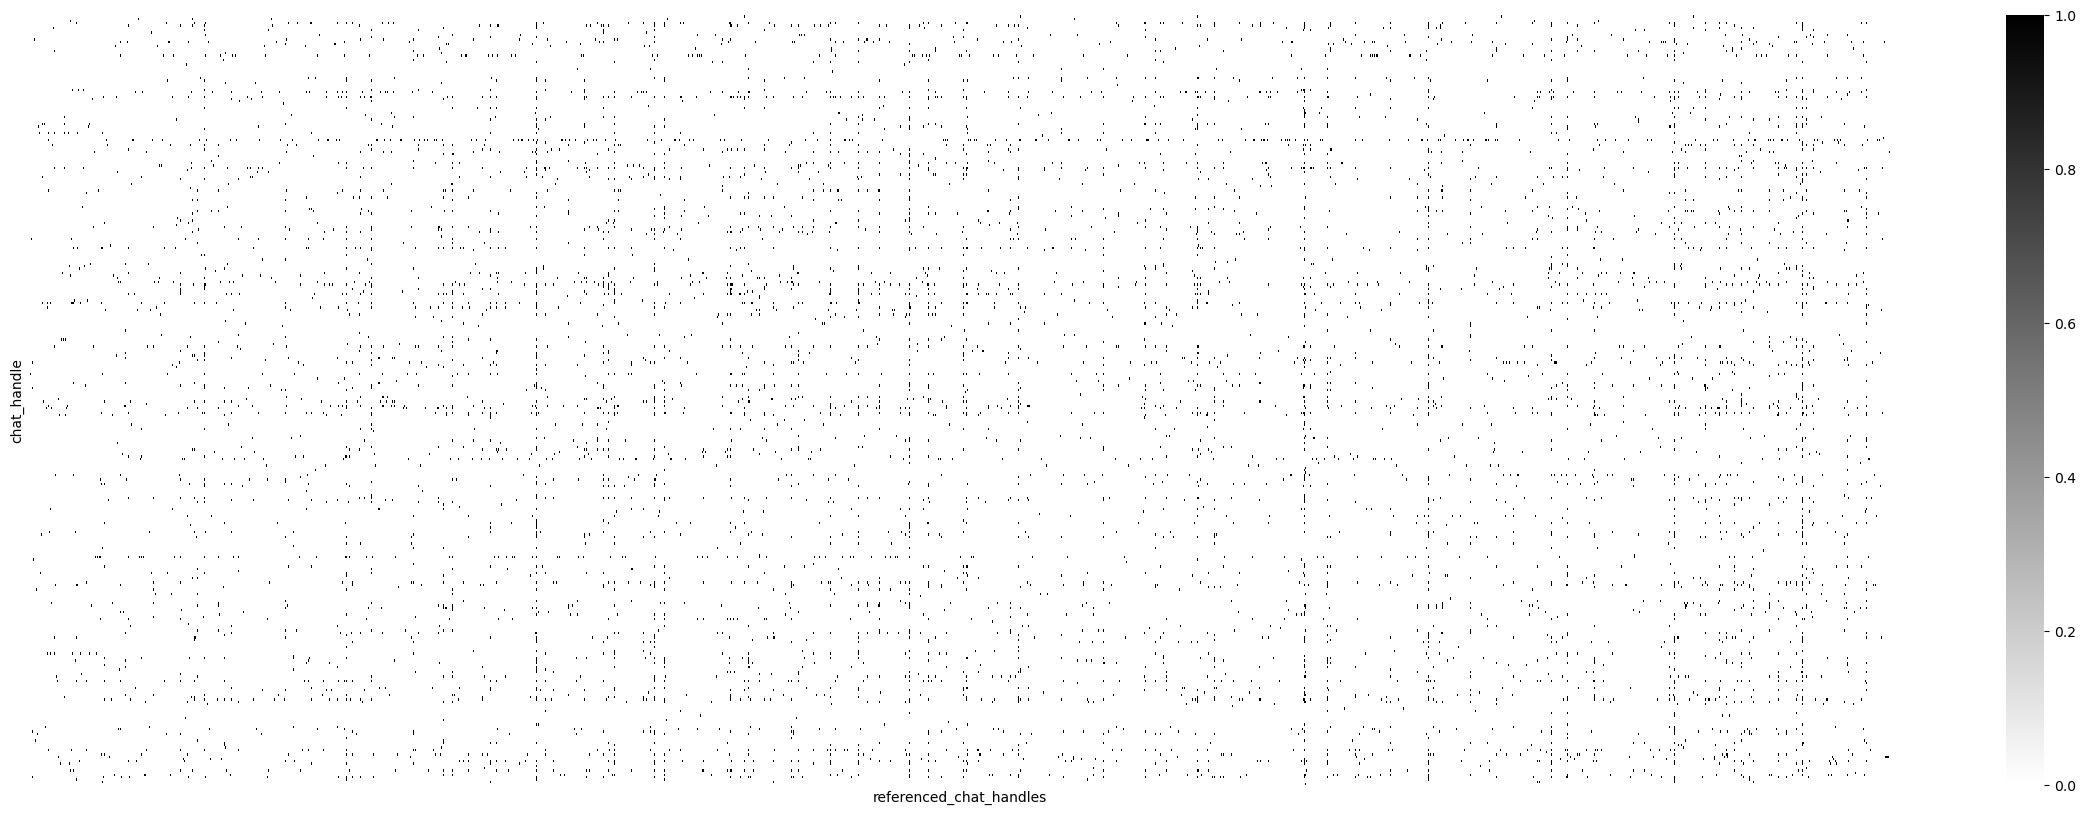

In [46]:
adj_matrix_ref_one_hot = adj_matrix_ref.map(lambda x: 0 if x==0 else 1)

# display the one hot encoded adjacency matrix
plt.figure(figsize=(30, 10))
sns.heatmap(adj_matrix_ref_one_hot, annot=False, cmap='gist_yarg')
plt.xticks([])
plt.yticks([])
plt.show()

# save the adjacency matrix
adj_matrix_ref_one_hot_path = os.path.join(os.getcwd(), "../features/2_onehot_ref_matrix.npy")
np.save(adj_matrix_ref_one_hot_path, adj_matrix_ref_one_hot)

## Feature 3: Webpage Previews

To include webpage information, we vectorize the webpage previews provided by telegram.

To do so, we'll:

1. Create Webpage Preview Embeddings

2. Aggregate Chat Representations by combining them with the message embeddings created earlier and aggregating them on their own.

#### 1. Create Webpage Preview Embeddings

In [ ]:
# check if the embeddings were already saved.
webpage_embeddings_path = os.path.join(os.getcwd(), '../features/0_webpage_embeddings.npy')
webpage_embeddings_df_path = os.path.join(os.getcwd(), '../features/0_webpage_embeddings.csv')
wp_already_vectorized = (os.path.isfile(webpage_embeddings_path) and os.path.isfile(webpage_embeddings_df_path))
print(f"Already created: {wp_already_vectorized}")

In [ ]:
# calculate embeddings if they have not already been created

if not wp_already_vectorized:
    
    print("Embeddings not yet created. Vectorizing...")
    
    # set environment variable to control tokenizers parallelism
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

    # define default embedding
    default_embedding = np.zeros((model.get_sentence_embedding_dimension(),))

    # split df into chunks for parallel processing
    num_chunks = 3 # Three seems to be fastest on the machine the code was written on.
    df_chunks = np.array_split(df_embeddings["webpage_description"], num_chunks)
    
    # set up the directory to save intermediate results
    output_dir = os.path.join(os.getcwd(), "../tmp")
    os.makedirs(output_dir, exist_ok=True)    

    # process each chunk in parallel and save intermediate results to limit the impact of crashes
    results = Parallel(n_jobs=num_chunks)(
        delayed(process_chunk_with_saving)(chunk, chunk_index, default_embedding, model, output_dir) 
        for chunk_index, chunk in enumerate(df_chunks)
    )

    # combine results into a single df
    df_embeddings["webpage_description_embeddings"] = np.concatenate(results).tolist()
    
    # save the results as a csv-file
    df_embeddings.to_csv(webpage_embeddings_df_path)
    print(df_embeddings.shape)
    
    # save the embeddings seperatly as a numpy array
    embeddings_array = np.array(df_embeddings["webpage_description_embeddings"].tolist())
    np.save(webpage_embeddings_path, embeddings_array)

    
else:
    # loading the whole dataframe takes about 45min. Instead we'll load only the embeddings and add them to the dataframe we loaded earlier
    print("Webpage embeddings already created. Loading Embeddings...") 
    #feature = ['webpage_description_embeddings']
    #embeddings = pd.read_csv(webpage_embeddings_df_path, skipinitialspace=True, usecols=feature)
    embeddings = np.load(webpage_embeddings_path)
    df_embeddings["webpage_description_embeddings"] = embeddings.tolist()
    

#### 2. Create Aggregated Chat Representations 

Next, we create two chat representations: 

1) One based on the preview embeddings.

2) One based on an aggregation of the preview and message embeddings.

In [ ]:
webpreview_chat_path = os.path.join(os.getcwd(), "../features/3_webpreview_chat_vectors.npy")
already_created =  os.path.exists(webpreview_chat_path)
print(f"Already created: {already_created}")

In [ ]:
if not already_created:
    print("No vectors found. Creating chat representations.")
    # for each chat: vertically stack the message embeddings into a matrix and take the mean for each column to create chat embeddings
    webpreview_chat_representations = df_embeddings.groupby('telegram_chat_id')['webpage_description_embeddings'].apply(aggregate_embeddings) 

    # save the representations
    webpreview_chat_representations.to_pickle(webpreview_chat_path)
    
else:
    print("Vectors found. Loading chat representations.")
    webpreview_chat_representations = pd.read_pickle(webpreview_chat_path)

In [ ]:
msg_webpreview_chat_path = os.path.join(os.getcwd(), "../features/03_msg_webpreview_chat_vectors.npy")
already_created =  os.path.exists(msg_webpreview_chat_path)
print(f"Already created: {already_created}")

In [ ]:
def combine_embeddings(row):
    """
    Combine message embeddings and webpage preview embeddings by taking their mean and ignoring zero embeddings
    Args:
        row (pd.Series(np.array)): a row of our dataframe, representing a message 
    Returns:
        np.array: The aggregated embeddings
    """        
    message_embedding = row["message_text_embeddings"]
    webpage_embedding = row["webpage_description_embeddings"]
    
    # Create a list of non-zero embeddings
    non_zero_embeddings = []
    
    if not np.all(message_embedding == 0):
        non_zero_embeddings.append(message_embedding)
    if not np.all(webpage_embedding == 0):
        non_zero_embeddings.append(webpage_embedding)
    
    # If we have valid embeddings, return the mean; otherwise return a zero vector
    if non_zero_embeddings:
        return np.mean(np.vstack(non_zero_embeddings), axis=0)
    else:
        return np.zeros_like(message_embedding)  # Return a zero vector if there's no valid embedding

# Check if vectors already exist
if not already_created:
    print("No vectors found. Creating chat representations.")
    
    # Create a new column that combines both the message text embedding and webpage embeddings for each message
    df_embeddings["combined_embedding"] = df_embeddings.apply(combine_embeddings, axis=1)
    
    # Use the aggregated messages embeddings to create chat vectors, ignoring zero embeddings
    msg_webpreview_chat_representations = df_embeddings.groupby('telegram_chat_id')['combined_embedding'].apply(aggregate_embeddings)

    # Save the representations
    msg_webpreview_chat_representations.to_pickle(msg_webpreview_chat_path)
    
else:
    print("Vectors found. Loading chat representations.")
    msg_webpreview_chat_representations = pd.read_pickle(msg_webpreview_chat_path)


In [ ]:
# compare the created embeddings to check, if the aggregation worked as expects
df_embeddings[["webpage_description_embeddings", "message_text_embeddings", "combined_embedding"]]